In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)
%matplotlib inline
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p

from numpy import inf

from sklearn.model_selection import train_test_split, KFold, cross_val_score, RepeatedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler

from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.linear_model import LinearRegression, Lars, Lasso, Ridge, ElasticNet, TheilSenRegressor, RANSACRegressor, HuberRegressor, ElasticNetCV
from sklearn.kernel_ridge import KernelRidge

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

import xgboost as xgb
import lightgbm as lgbm
from catboost import CatBoostRegressor

def ignore_warn(*args, **kwargs):
    pass
import warnings
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

In [2]:
train = pd.read_csv('input/train.csv')
print("Training dataset has {} samples with {} features each.".format(*train.shape))
# sale_price_raw = train['SalePrice']
# train_id = train['Id']
# train = train.drop(['Id', 'SalePrice'], axis = 1)
train.head()

Training dataset has 1460 samples with 81 features each.


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
test = pd.read_csv('input/test.csv')
print("Testing dataset has {} samples with {} features each.".format(*test.shape))
test_id = test['Id']
# test = test.drop(['Id'], axis = 1)
test.head()

Testing dataset has 1459 samples with 80 features each.


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


### Data Exploration

In [4]:
# any missing values?
train.columns[train.isnull().any()]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

Quite a few attributes are missing values. Let's understand the % of missing values.

In [5]:
missing_df = train.isnull().sum()/len(train)
missing_df = missing_df[missing_df > 0]
missing_df.sort_values(inplace=True)
missing_df

Electrical      0.000685
MasVnrType      0.005479
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtFinType1    0.025342
BsmtExposure    0.026027
BsmtFinType2    0.026027
GarageCond      0.055479
GarageQual      0.055479
GarageFinish    0.055479
GarageType      0.055479
GarageYrBlt     0.055479
LotFrontage     0.177397
FireplaceQu     0.472603
Fence           0.807534
Alley           0.937671
MiscFeature     0.963014
PoolQC          0.995205
dtype: float64

PoolQC is missing most of its values, followed by MiscFeature and Alley. We can use a bar plot to visualize these.

In [6]:
missing_df = missing_df.to_frame()
missing_df.columns = ['count']
missing_df.index.names = ['Name']
missing_df['Name'] = missing_df.index

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text xticklabel objects>)

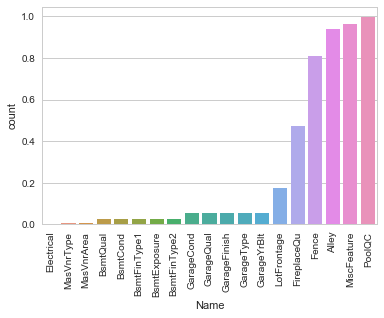

In [7]:
#plot the missing value count
sns.set(style="whitegrid", color_codes=True)
ax = sns.barplot(x = 'Name', y = 'count', data=missing_df)
plt.xticks(rotation = 90)

For a regression problem it is better to have a normally distributed target variable i.e without skewness. Lets check that.


 mu = 180921.20 and sigma = 79415.29



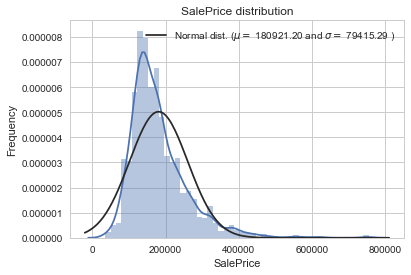

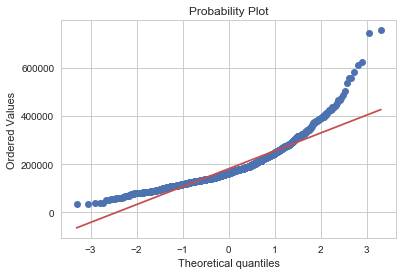

In [8]:
sns.distplot(train['SalePrice'] , fit=norm);
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

We can see that the target variable is right-skewed. 

In [9]:
print ("The skewness of SalePrice is {}".format(train['SalePrice'].skew()))

The skewness of SalePrice is 1.8828757597682129


One of the ways to handle skewness is by doing a logarithmic transformation. Lets try that.

In [10]:
target = np.log(train['SalePrice'])

Lets check the skewness and re-run the distribution plot again.

In [11]:
print ("The skewness of SalePrice is {}".format(target.skew()))
# The skewness of SalePrice is 0.12133506220520406

The skewness of SalePrice is 0.12133506220520406



 mu = 12.02 and sigma = 0.40



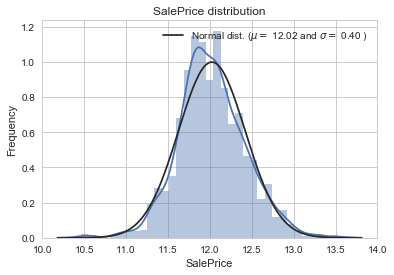

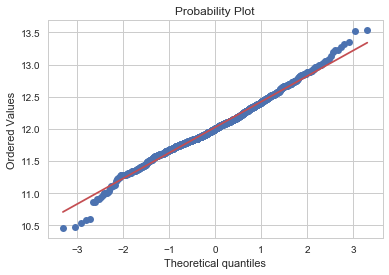

In [12]:
sns.distplot(target, fit=norm);
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(target)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(target, plot=plt)
plt.show()
# mu = 12.02 and sigma = 0.40

The plot is normalized as seen by the mean and standard deviation.

To help us analyze the numeric and categorical attributes lets separate these out.

In [13]:
numeric_df = train.select_dtypes(include=[np.number])
cat_df = train.select_dtypes(exclude=[np.number])
print ("There are {} numeric and {} categorical columns in train data".format(numeric_df.shape[1], cat_df.shape[1]))

There are 38 numeric and 43 categorical columns in train data


Lets understand the correlation between the numeric attributes and the sale price.

In [14]:
numeric_df.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


Lets drop the id column before we run the correlation because it is not going to give us any meaningful information. Also, MSSubClass is a categorical attribute so lets change the datatype for that.

In [15]:
# train['MSSubClass'] = train['MSSubClass'].astype('category')
# test['MSSubClass'] = test['MSSubClass'].astype('category')

# numeric_df = train.select_dtypes(include=[np.number])
numeric_df = numeric_df.drop(['Id'], axis = 1)
# cat_df = train.select_dtypes(exclude=[np.number])
# print ("There are {} numeric and {} categorical columns in train data".format(numeric_df.shape[1], cat_df.shape[1]))

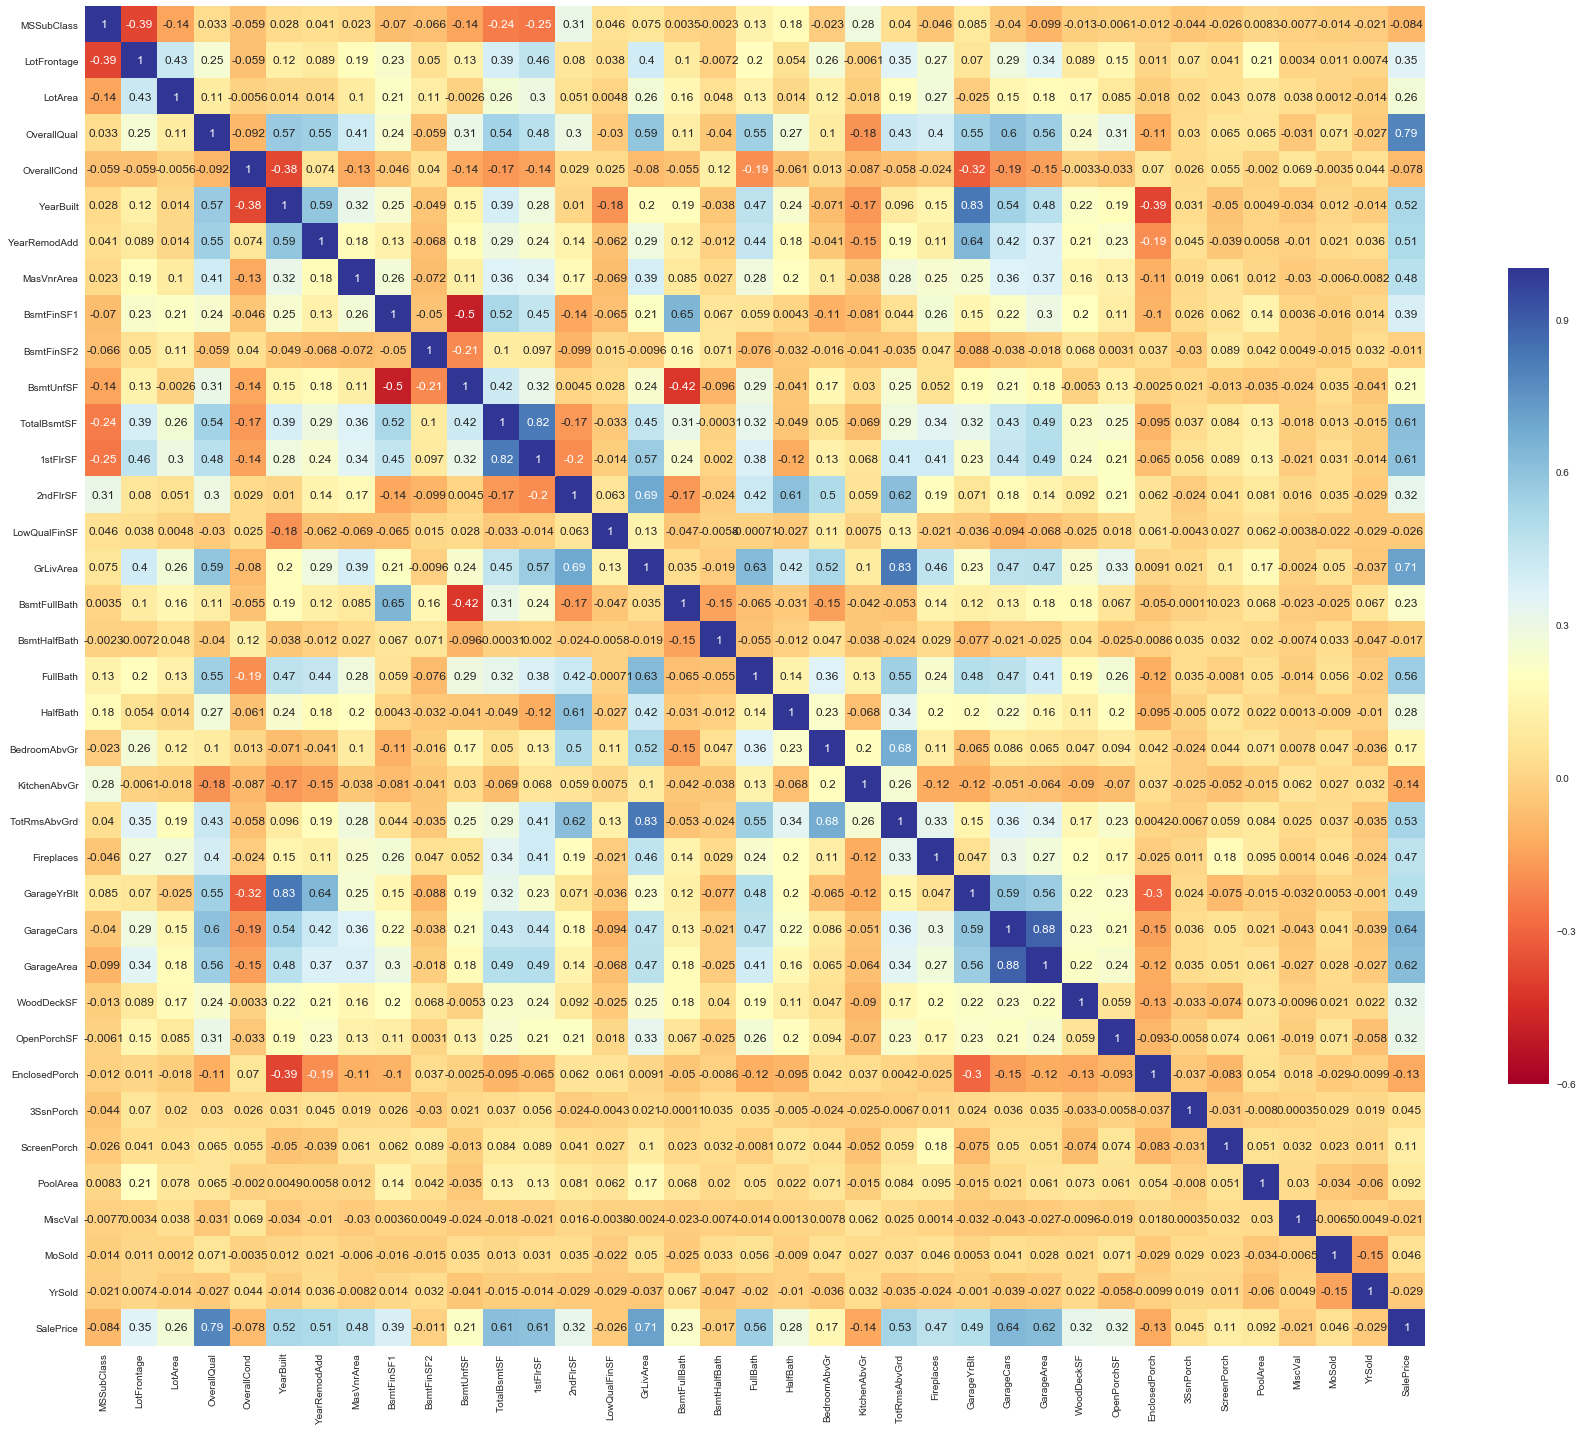

In [16]:
corr = numeric_df.corr()
plt.subplots(figsize=(30, 30))
cmap = sns.diverging_palette(150, 250, as_cmap=True)
sns.heatmap(corr, cmap="RdYlBu", vmax=1, vmin=-0.6, center=0.2, square=True, linewidths=0, cbar_kws={"shrink": .5}, annot = True);

The last row displays the correlation between SalePrice and the other attributes. OverlAllQual seems to be more correlated with SalePrice. Lets display these values in a more readable form.

In [17]:
print (corr['SalePrice'].sort_values(ascending=False))

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


Let's analyze the OverallQual attribute a little more.

In [18]:
train['OverallQual'].unique()

array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2], dtype=int64)

The over all quality is measured on a scale from 1 to 10. Based on the description provided this "Rates the overall material and finish of the house" from Very Poor(1) to Very Excellent(10). So keeping this as an ordinal value makes sense.
Lets understand how this relates to SalePrice. 

             SalePrice
OverallQual           
1                50150
2                60000
3                86250
4               108000
5               133000
6               160000
7               200141
8               269750
9               345000
10              432390


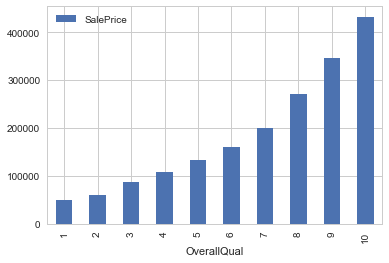

In [19]:
#we are using median because the SalePrice is skewed
pivot = train.pivot_table(index='OverallQual', values='SalePrice', aggfunc=np.median)
print(pivot.sort_values(by='OverallQual'))
pivot.plot(kind='bar')

As the quality increases the SalePrice is also increasing. People do care about the Quality of the house they are buying.

Now lets analyze a little more about GrLivArea, which seems to have the next highest correlation with SalePrice. Since there are too many different values for GrLiveArea a bar plot as did with OverAllQual will not help. So we will use a jointplot.

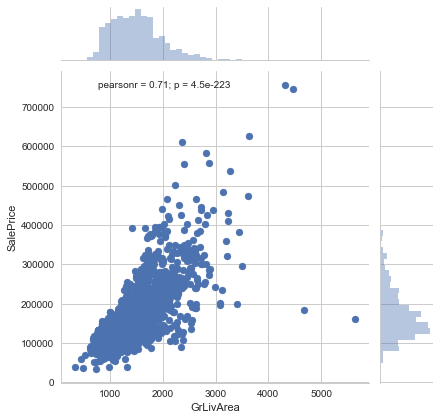

In [20]:
sns.jointplot(x=train['GrLivArea'], y=train['SalePrice'])

In the above plot, the correlation between SalePrice and LivingArea can be seen and also Pearson Correlation is also mentioned. There is also an outlier which shows a house with more than 5000 square feet sold for less than $200,000. So we will drop this row.

Now let us create histograms for the numeric attributes to understand skewness.

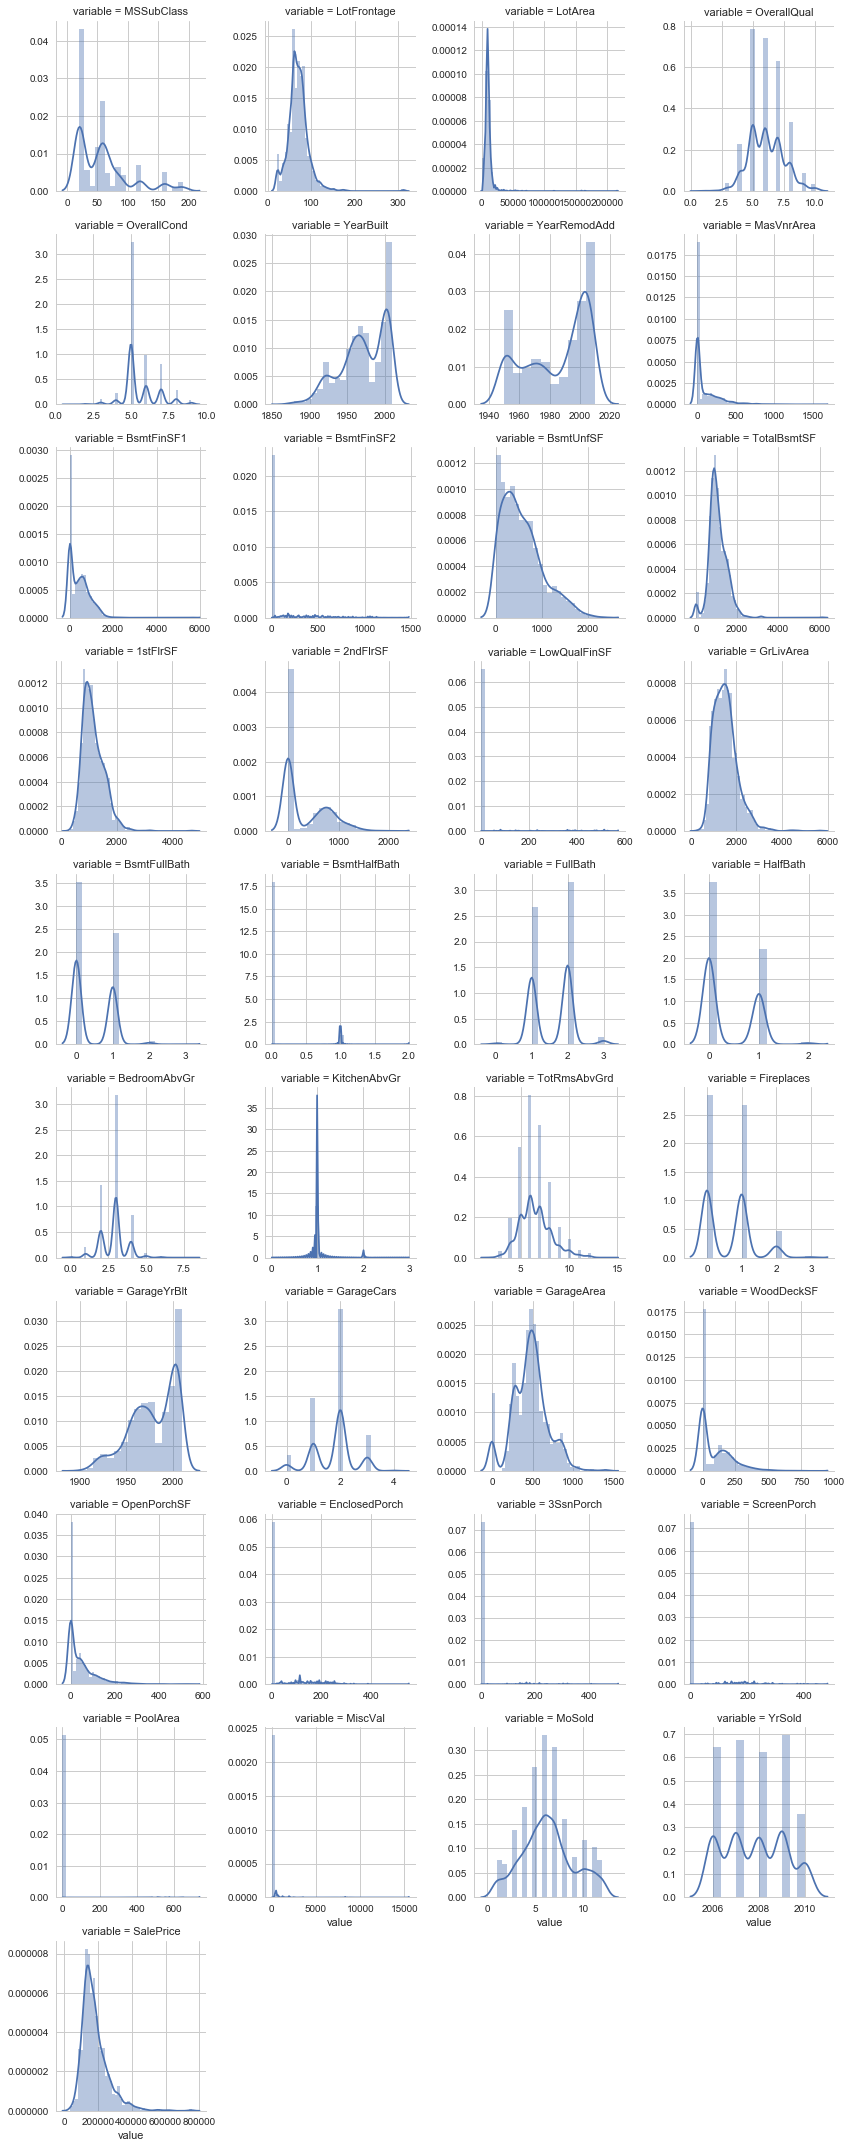

In [21]:
num = [f for f in train.columns if train.dtypes[f] != 'object']
num.remove('Id')
nd = pd.melt(train, value_vars = num)
n1 = sns.FacetGrid (nd, col='variable', col_wrap=4, sharex=False, sharey = False)
n1 = n1.map(sns.distplot, 'value')
n1

Most of the features are skewed. We can either use boxcox or the logarathmic function that we used for SalePrice. We will address this in the next section.

Now let us look at the categorical features. We will use ANOVA test to understand correlation between SalePrice and the categorical features. This test tells us whether there is a significant difference in the mean of groups. 

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\scipy\stats\stats.py:2923: RuntimeWarning: invalid value encountered in double_scalars
  ssbn += _square_of_sums(a - offset) / float(len(a))


<module 'matplotlib.pyplot' from 'd:\\Tools\\Miniconda3\\envs\\py_3_6_5_keras\\lib\\site-packages\\matplotlib\\pyplot.py'>

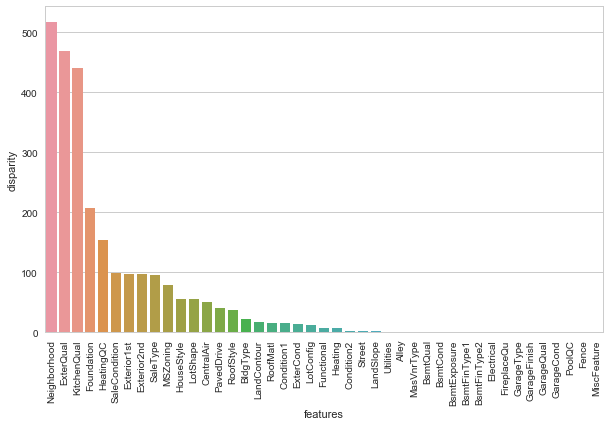

In [22]:
cat_attribs = [f for f in train.columns if train.dtypes[f] == 'object']

def anova(frame):
    anv = pd.DataFrame()
    anv['features'] = cat_attribs
    pvals = []
    for cat_attrib in cat_attribs:
       samples = []
       for cls in frame[cat_attrib].unique():
              s = frame[frame[cat_attrib] == cls]['SalePrice'].values
              samples.append(s)
       pval = stats.f_oneway(*samples)[1]
       pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

cat_df['SalePrice'] = train.SalePrice.values
k = anova(cat_df) 
k['disparity'] = np.log(1./k['pval'].values) 
plt.figure(figsize=(10, 6))
sns.barplot(data=k, x = 'features', y='disparity') 
plt.xticks(rotation=90)
plt 

Neighborhood seems to be the most important feature followed by ExterQual and KitchenQual, etc.

Lets create box plots for the categorical features to get some more insight.

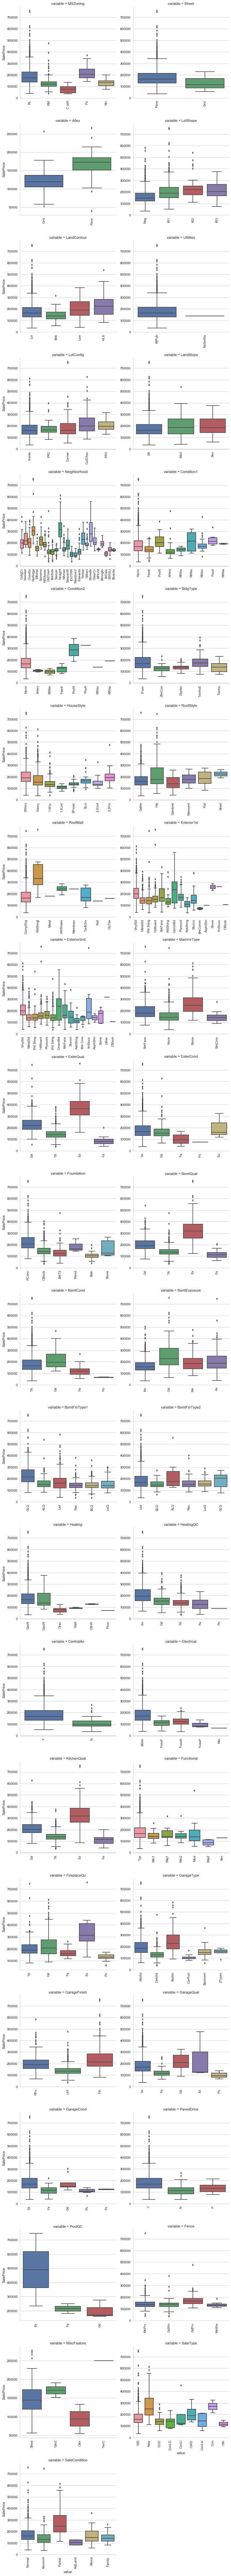

In [23]:
def boxplot(x,y,**kwargs):
            sns.boxplot(x=x,y=y)
            x = plt.xticks(rotation=90)

cat = [f for f in train.columns if train.dtypes[f] == 'object']

p = pd.melt(train, id_vars='SalePrice', value_vars=cat)
g = sns.FacetGrid (p, col='variable', col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, 'value','SalePrice')
g

Almost all the features possess outliers. So a tree based model will better suit our data.

### Data Pre-Processing
We will take care of missing values, outliers and encode categorical attributes.

In GrLivArea there were some outliers. Lets remove those.

In [24]:
train.drop(train[train['GrLivArea'] > 4000].index, inplace=True)
print("Training dataset has {} samples with {} features each.".format(*train.shape))

Training dataset has 1456 samples with 81 features each.


In [25]:
ntrain = train.shape[0]
ntest = test.shape[0]
data = pd.concat((train, test)).reset_index(drop=True)
print("Combined dataset of training and testing has {} samples with {} features each.".format(*data.shape))

Combined dataset of training and testing has 2915 samples with 81 features each.


### Handling NaNs

After going through the data_description.txt:
1. BsmtFullBath, BsmtHalfBath, MasVnrArea, BsmtUnfSF, TotalBsmtSF, GarageCars, BsmtFinSF2, BsmtFinSF1 and GarageArea will be defaulted to 0.
2. MSZoning, SaleType, Utilities, Exterior1st, Exterior2nd, MasVnrType, Electrical, KitchenQual and LotFrontage will be defaulted to the most frequently occuring value.
3. GarageType, Fence, MiscFeature, Alley, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, FireplaceQu, GarageFinish, GarageQual, GarageCond and PoolQC will be defaulted to 'NA'.
4. The attribute 'Functional' will have a default of 'Typ'
5. The attribute 'GarageYrBlt' will be defaulted to the same year as YearBuilt.

In [26]:
default_to_zero = ['BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea','BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 
                  'BsmtFinSF2', 'BsmtFinSF1', 'GarageArea']
for attrib in default_to_zero:
    data[attrib].fillna(0, inplace=True)

default_to_frequent = ['MSZoning', 'SaleType', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Electrical', 
                       'KitchenQual']
for attrib in default_to_frequent:
    data[attrib] = data[attrib].fillna(data[attrib].mode()[0])
    
default_to_na = ['GarageType', 'Fence', 'MiscFeature', 'Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                 'BsmtFinType2', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC']
for attrib in default_to_na:
    data[attrib].fillna('NA', inplace=True)
    
data['Functional'].fillna("Typ", inplace=True)
data.loc[data.GarageYrBlt.isnull(),'GarageYrBlt'] = data.loc[data.GarageYrBlt.isnull(),'YearBuilt']

I liked the idea of predicting the LotFrontage values using a linear model. Thanks to [Jack Roberts](https://www.kaggle.com/jack89roberts/top-7-using-elasticnet-with-interactions)

----------------
Intercept: 62.63281181934695
----------------
LotArea            68.440303
PoolArea           27.582787
RoofStyle_Shed     25.287250
1stFlrSF           24.280397
GrLivArea          21.015013
Foundation_Wood    20.347152
PoolQC_Ex          16.289249
BldgType_2fmCon    16.154764
Condition1_PosA    15.473404
GarageArea         15.430853
dtype: float64
----------------
RoofStyle_Gambrel     -10.276564
PoolQC_Fa             -11.292893
PoolQC_Gd             -11.602928
BsmtCond_Po           -11.819402
Exterior2nd_Brk Cmn   -12.098414
BldgType_TwnhsE       -12.311297
Exterior1st_CemntBd   -15.247614
BldgType_Twnhs        -18.123649
GarageYrBlt           -21.559562
LotConfig_CulDSac     -23.086538
dtype: float64
----------------
R2: 0.674402372587547
----------------


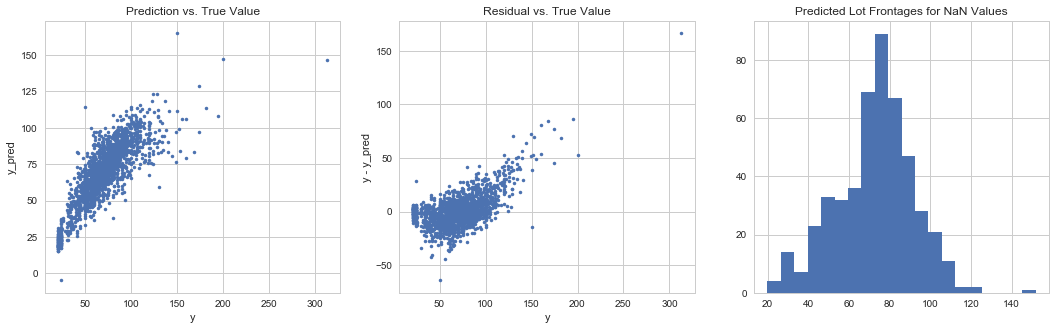

In [27]:
# function to normalise a column of values to lie between 0 and 1
def scale_minmax(col):
    return (col-col.min())/(col.max()-col.min())

#LotFrontage
# fill nan values using a linear regressor

# convert categoricals to dummies, exclude SalePrice from model
df_frontage = pd.get_dummies(data.drop('SalePrice',axis=1))

# normalise columns to 0-1
for col in df_frontage.drop('LotFrontage',axis=1).columns:
    df_frontage[col] = scale_minmax(df_frontage[col])

lf_train = df_frontage.dropna()
lf_train_y = lf_train.LotFrontage
lf_train_X = lf_train.drop('LotFrontage',axis=1)  

# fit model
lr = Ridge()
lr.fit(lf_train_X, lf_train_y)

# check model results
lr_coefs = pd.Series(lr.coef_,index=lf_train_X.columns)

print('----------------')
print('Intercept:',lr.intercept_)
print('----------------')
print(lr_coefs.sort_values(ascending=False).head(10))
print('----------------')
print(lr_coefs.sort_values(ascending=False).tail(10))
print('----------------')
print('R2:',lr.score(lf_train_X,lf_train_y))
print('----------------')

lf_pred_y = lr.predict(lf_train_X)
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.plot(lf_train_y,lf_pred_y,'.')
plt.xlabel('y')
plt.ylabel('y_pred');
plt.title('Prediction vs. True Value')

plt.subplot(1,3,2)
plt.plot(lf_train_y, lf_train_y-lf_pred_y,'.')
plt.xlabel('y')
plt.ylabel('y - y_pred');
plt.title('Residual vs. True Value')


# fill na values using model predictions
nan_frontage = data.LotFrontage.isnull()
X = df_frontage[nan_frontage].drop('LotFrontage',axis=1)
y = lr.predict(X)

plt.subplot(1,3,3)
plt.hist(y,bins=20)
plt.title('Predicted Lot Frontages for NaN Values')

# fill nan values
data.loc[nan_frontage,'LotFrontage'] = y
del y

In [28]:
# any more missing values?
data.columns[data.isnull().any()]

Index(['SalePrice'], dtype='object')

After going through the data_description.txt following attributes can be treated as categorical. So we will update the datatype to be category.

Below features can be converted to numeric scale:
OverallQual, OverallCond, ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, HeatingQC, CentralAir, KitchenQual, FireplaceQu, GarageFinish, GarageQual, GarageCond, PavedDrive, PoolQC

Below features can be treated as numeric:
LotFrontage, LotArea, YearBuilt, YearRemodAdd, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, Bedroom, Kitchen, TotRmsAbvGrd, Fireplaces, GarageYrBlt, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal, MoSold,
YrSold

In [29]:
# all_data = all_data.drop(['Utilities'], axis=1)
print('Values in training data for feature {} is {}'.format('Utilites', train['Utilities'].value_counts()))
print('-'*80)
print('Values in testing data for feature {} is {}'.format('Utilites', test['Utilities'].value_counts()))
print('-'*80)
utilities_nan = data['Utilities'].isnull().sum()
print('# of missing values in Utilities is {}'.format(utilities_nan))

Values in training data for feature Utilites is AllPub    1455
NoSeWa       1
Name: Utilities, dtype: int64
--------------------------------------------------------------------------------
Values in testing data for feature Utilites is AllPub    1457
Name: Utilities, dtype: int64
--------------------------------------------------------------------------------
# of missing values in Utilities is 0


Testing dataset contains values of 'AllPub' and 2 missing values. While Training dataset contains values of 'AllPub' but for one record that contains a value of 'NoSeWa'. If we impute this column we will impute it with 'Most Frequent Values', which will be 'AllPub' and this will make the column non-differentiable. So it is safe to drop this column.

In [30]:
data = data.drop(['Utilities'], axis=1)

### Feature Engneering


After going through the data_description.txt following attributes can be treated as categorical. So we will update the datatype to be category.

In [31]:
cat_attribs = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 
               'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 
               'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'Fence', 'MiscFeature', 
               'SaleType', 'SaleCondition']

for attrib in cat_attribs:
    data[attrib] = data[attrib].astype('category')

for cat_attrib in cat_attribs:
    print(data[cat_attrib].value_counts())

20     1079
60      571
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64
RL         2265
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64
Pave    2903
Grvl      12
Name: Street, dtype: int64
NA      2717
Grvl     120
Pave      78
Name: Alley, dtype: int64
Reg    1859
IR1     965
IR2      76
IR3      15
Name: LotShape, dtype: int64
Lvl    2620
HLS     120
Bnk     115
Low      60
Name: LandContour, dtype: int64
Inside     2132
Corner      508
CulDSac     176
FR2          85
FR3          14
Name: LotConfig, dtype: int64
Gtl    2774
Mod     125
Sev      16
Name: LandSlope, dtype: int64
NAmes      443
CollgCr    267
OldTown    239
Edwards    192
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber 

Plotting a barchart will give us a better idea on how the different values are distributed.

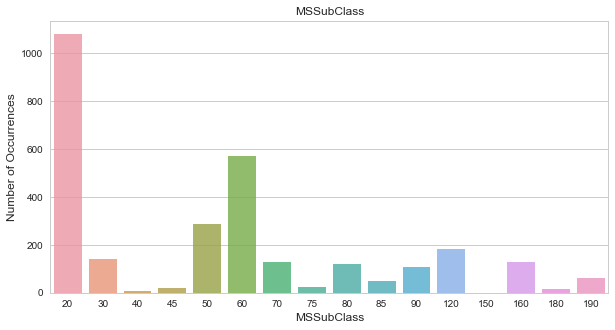

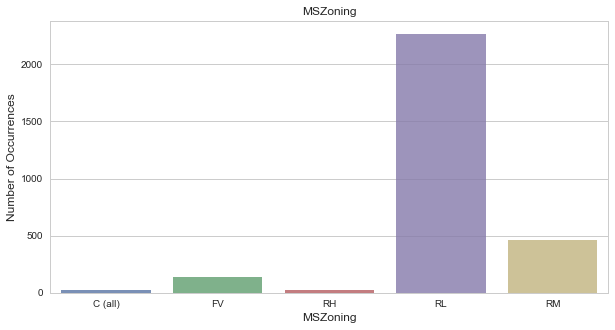

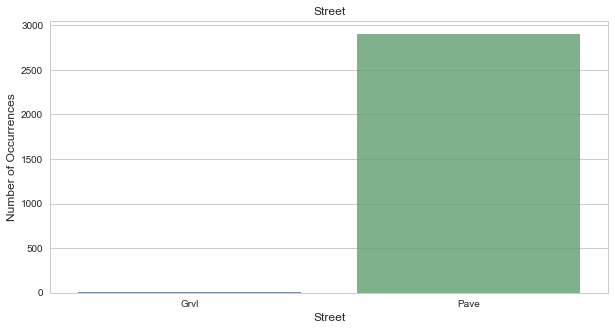

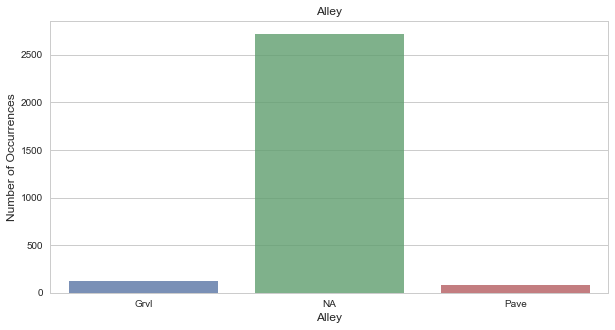

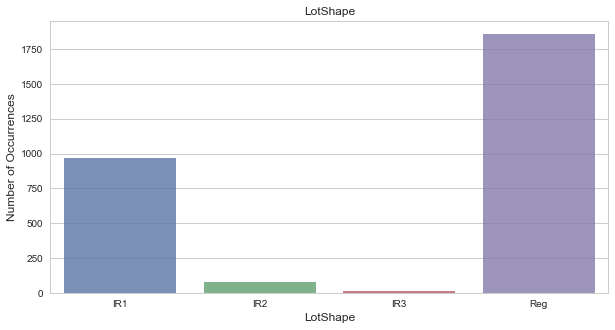

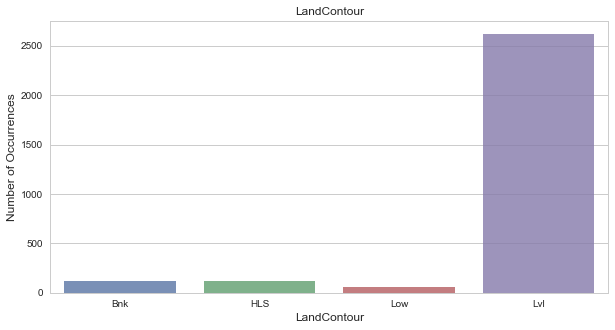

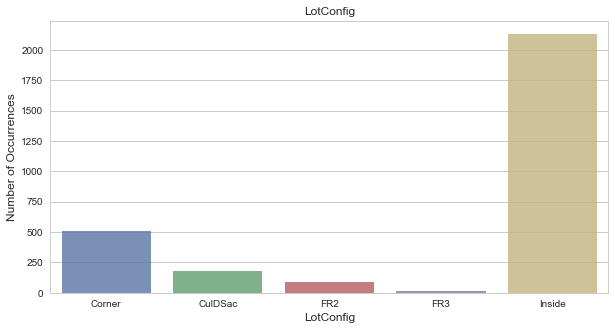

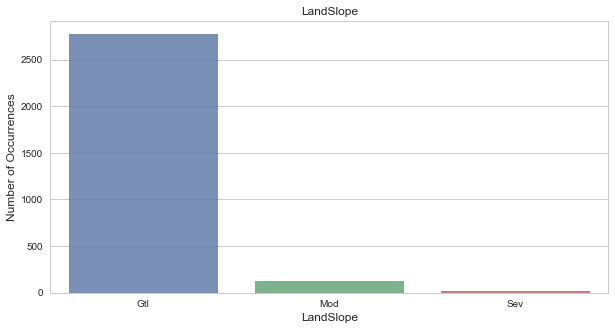

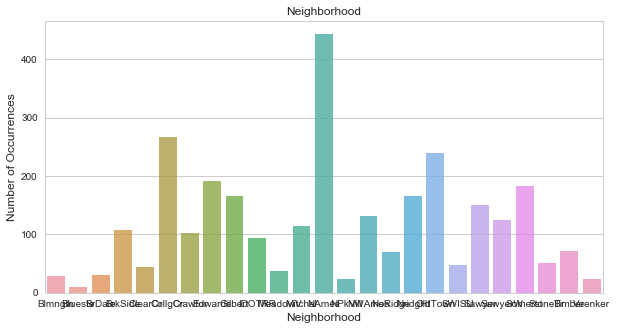

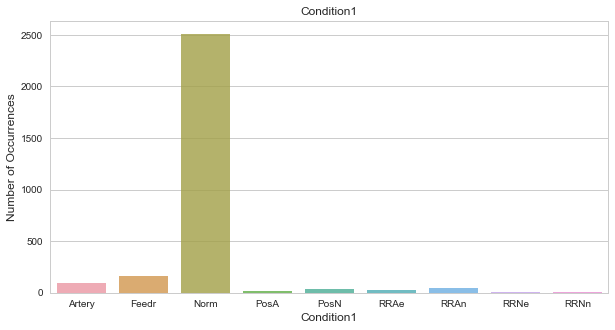

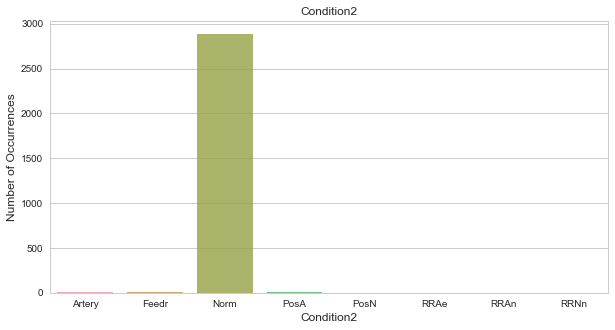

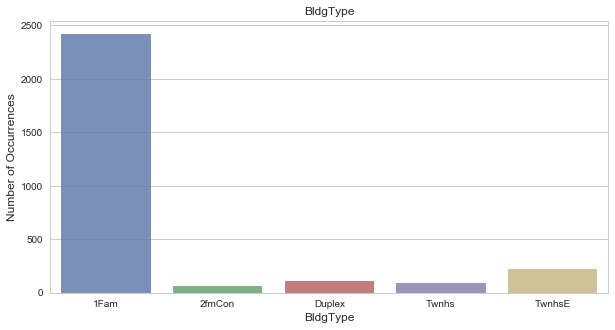

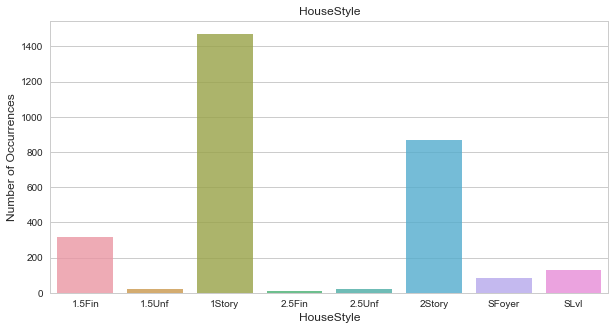

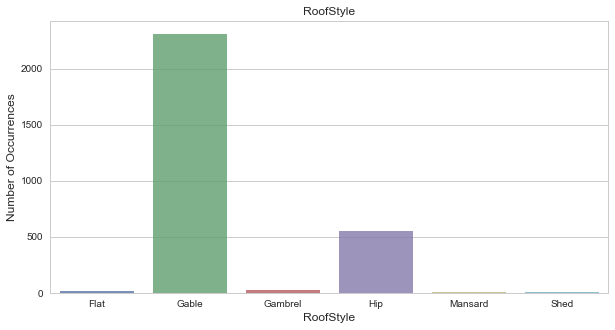

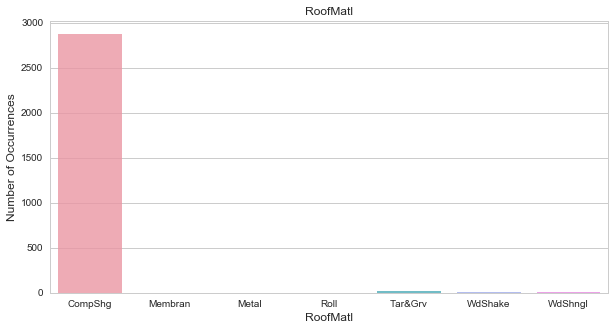

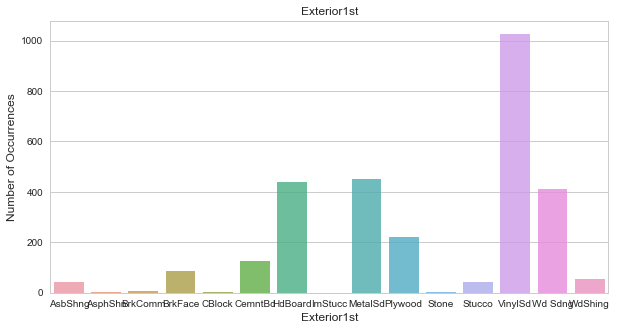

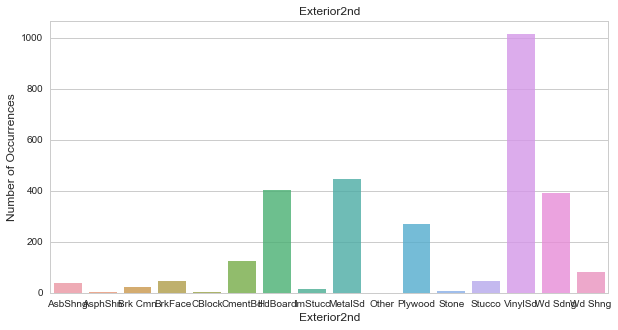

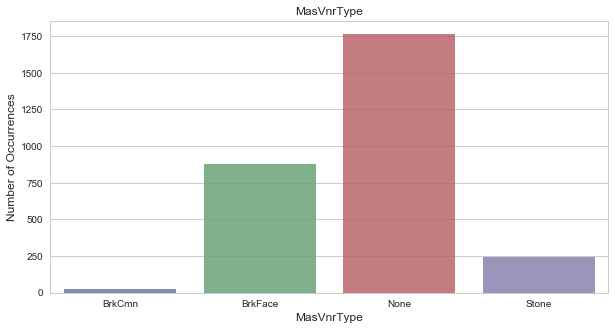

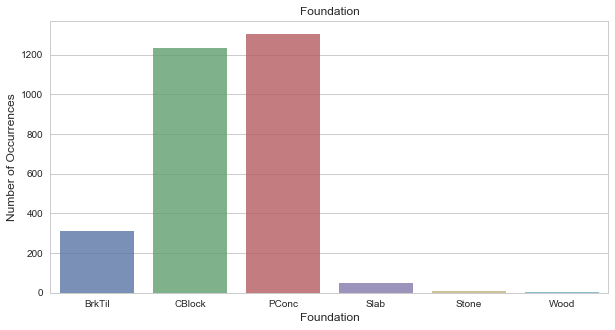

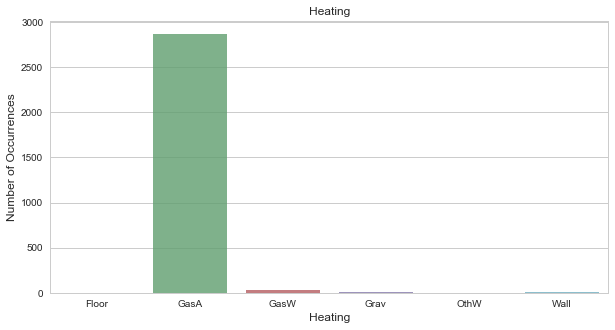

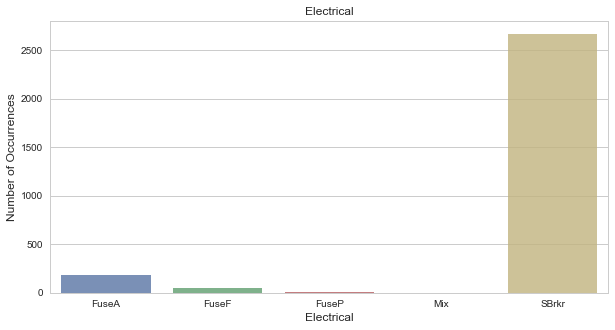

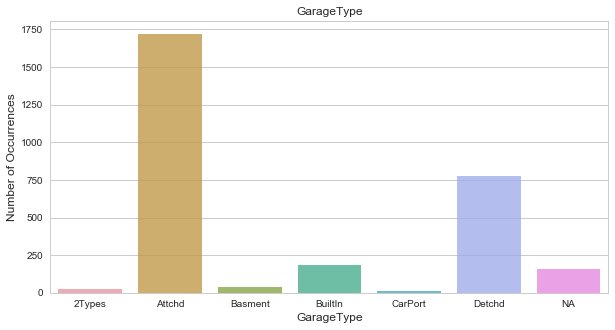

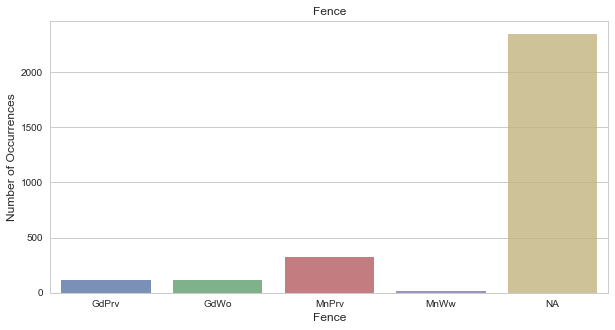

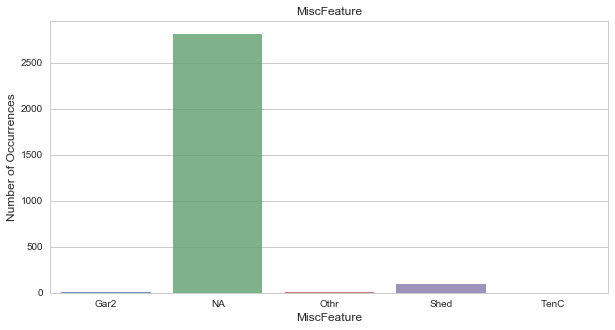

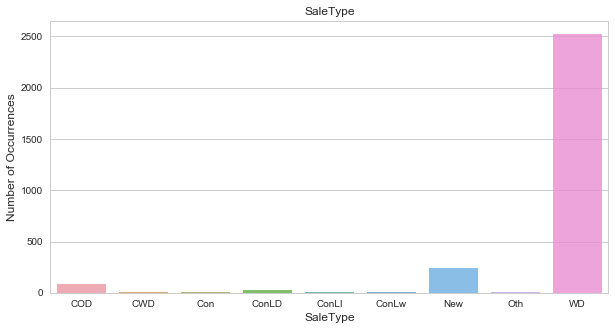

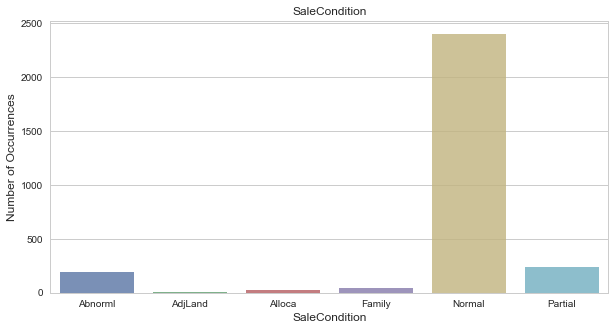

In [32]:
for cat_attrib in cat_attribs:
    attrib_count  = data[cat_attrib].value_counts()
    plt.figure(figsize=(10,5))
    sns.barplot(attrib_count.index, attrib_count.values, alpha=0.8)
    plt.title(cat_attrib)
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel(cat_attrib, fontsize=12)
    plt.show()

Since only one value seems to be dominant, we will create a new column to indicate the presence of that value.

In [33]:
data["IsRegularLotShape"] = (data["LotShape"] == "Reg") * 1
data["IsLandLevel"] = (data["LandContour"] == "Lvl") * 1
data["IsLandSlopeGentle"] = (data["LandSlope"] == "Gtl") * 1
data["IsElectricalSBrkr"] = (data["Electrical"] == "SBrkr") * 1
data["IsGarageDetached"] = (data["GarageType"] == "Detchd") * 1
data["IsPavedDrive"] = (data["PavedDrive"] == "Y") * 1
data["HasShed"] = (data["MiscFeature"] == "Shed") * 1
data["Remodeled"] = (data["YearRemodAdd"] != data["YearBuilt"]) * 1

#Did the remodeling happen during the sale year?
data["RecentRemodel"] = (data["YearRemodAdd"] == data["YrSold"]) * 1

# Was this house sold in the year it was built?
data["VeryNewHouse"] = (data["YearBuilt"] == data["YrSold"]) * 1
data["Has2ndFloor"] = (data["2ndFlrSF"] == 0) * 1
data["HasMasVnr"] = (data["MasVnrArea"] == 0) * 1
data["HasWoodDeck"] = (data["WoodDeckSF"] == 0) * 1
data["HasOpenPorch"] = (data["OpenPorchSF"] == 0) * 1
data["HasEnclosedPorch"] = (data["EnclosedPorch"] == 0) * 1
data["Has3SsnPorch"] = (data["3SsnPorch"] == 0) * 1
data["HasScreenPorch"] = (data["ScreenPorch"] == 0) * 1

#setting levels with high count as 1 and the rest as 0
#you can check for them using the value_counts function
data["HighSeason"] = data["MoSold"].replace({1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})
data["NewerDwelling"] = data["MSSubClass"].replace({20: 1, 30: 0, 40: 0, 45: 0,50: 0, 60: 1, 70: 0, 75: 0, 80: 0, 85: 0, 90: 0, 120: 1, 150: 0, 160: 0, 180: 0, 190: 0})

In [34]:
print("New dataset contains {} samples with {} features each.".format(*data.shape))

New dataset contains 2915 samples with 99 features each.


In [35]:
data["SaleCondition_PriceDown"] = data.SaleCondition.replace({'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0})

# house completed before sale or not
data["BoughtOffPlan"] = data.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})
data["BadHeating"] = data.HeatingQC.replace({'Ex': 0, 'Gd': 0, 'TA': 0, 'Fa': 1, 'Po': 1})

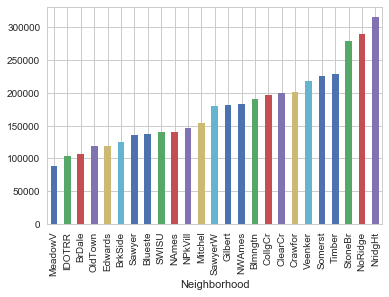

In [36]:
#calculating total area using all area columns
area_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', '1stFlrSF', 
             '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
             'LowQualFinSF', 'PoolArea' ]

data["TotalArea"] = data[area_cols].sum(axis=1)
data["TotalArea1st2nd"] = data["1stFlrSF"] + data["2ndFlrSF"]
data["Age"] = 2010 - data["YearBuilt"]
data["TimeSinceSold"] = 2010 - data["YrSold"]
data["SeasonSold"] = data["MoSold"].map({12:0, 1:0, 2:0, 3:1, 4:1, 5:1, 6:2, 7:2, 8:2, 9:3, 10:3, 11:3}).astype(int)
data["YearsSinceRemodel"] = data["YrSold"] - data["YearRemodAdd"]

#grouping neighborhood variable based on this plot
train['SalePrice'].groupby(train['Neighborhood']).median().sort_values().plot(kind='bar')

The graph above gives us a hint on how to combine levels of the neighborhood variable into fewer levels. We can combine bars of somewhat equal height in one category. 

In [37]:
neighborhood_map = {"MeadowV" : 0, "IDOTRR" : 1, "BrDale" : 1, "OldTown" : 1, "Edwards" : 1, "BrkSide" : 1,
                    "Sawyer" : 1, "Blueste" : 1, "SWISU" : 2, "NAmes" : 2, "NPkVill" : 2, "Mitchel" : 2, "SawyerW" : 2, 
                    "Gilbert" : 2, "NWAmes" : 2, "Blmngtn" : 2, "CollgCr" : 2, "ClearCr" : 3, "Crawfor" : 3, "Veenker" : 3,
                    "Somerst" : 3, "Timber" : 3, "StoneBr" : 4, "NoRidge" : 4, "NridgHt" : 4}

data['NeighborhoodBin'] = data['Neighborhood'].map(neighborhood_map)
data.loc[data.Neighborhood == 'NridgHt', "Neighborhood_Good"] = 1
data.loc[data.Neighborhood == 'Crawfor', "Neighborhood_Good"] = 1
data.loc[data.Neighborhood == 'StoneBr', "Neighborhood_Good"] = 1
data.loc[data.Neighborhood == 'Somerst', "Neighborhood_Good"] = 1
data.loc[data.Neighborhood == 'NoRidge', "Neighborhood_Good"] = 1
data["Neighborhood_Good"].fillna(0, inplace=True)
data["SaleCondition_PriceDown"] = data.SaleCondition.replace({'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0})

# House completed before sale or not
data["BoughtOffPlan"] = data.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})
data["BadHeating"] = data.HeatingQC.replace({'Ex': 0, 'Gd': 0, 'TA': 0, 'Fa': 1, 'Po': 1})
print("New dataset contains {} samples with {} features each.".format(*data.shape))

New dataset contains 2915 samples with 110 features each.


Lets one-hot encode the categorical attributes

In [38]:
dummies = pd.get_dummies(data[cat_attribs])
data = data.join(dummies)
data = data.drop(cat_attribs, axis=1)
print("New dataset contains {} samples with {} features each.".format(*data.shape))

New dataset contains 2915 samples with 278 features each.


In [39]:
print("New dataset contains {} samples with {} features each.".format(*data.shape))

New dataset contains 2915 samples with 278 features each.


In [40]:
qual_dict = {np.nan: 0, "NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
name = np.array(['ExterQual','PoolQC','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','FireplaceQu', 
                 'GarageQual','GarageCond'])

for i in name:
    data[i] = data[i].map(qual_dict).astype(int)

data["BsmtExposure"] = data["BsmtExposure"].map({np.nan: 0, "NA": 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}).astype(int)

bsmt_fin_dict = {np.nan: 0, "NA": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
data["BsmtFinType1"] = data["BsmtFinType1"].map(bsmt_fin_dict).astype(int)
data["BsmtFinType2"] = data["BsmtFinType2"].map(bsmt_fin_dict).astype(int)

data["CentralAir"] = (data["CentralAir"] == "Y") * 1.0
data["GarageFinish"] = data["GarageFinish"].map({np.nan: 0,"NA": 0, "Unf": 1, "RFn": 2, "Fin": 3}).astype(int)
data["PavedDrive"] = data["PavedDrive"].map({"N": 0, "P": 1, "Y": 2}).astype(int)

data['Functional'].replace({'Typ':7,'Min1':6,'Min2':5,'Mod':4,'Maj1':3,'Maj2':2,'Sev':1,'Sal':0}, inplace=True)


# Simplifications of existing features into bad/average/good based on counts
data["SimplOverallQual"] = data.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
data["SimplOverallCond"] = data.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
data["SimplPoolQC"] = data.PoolQC.replace({1 : 1, 2 : 1, 3 : 2, 4 : 2})
data["SimplGarageCond"] = data.GarageCond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
data["SimplGarageQual"] = data.GarageQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
data["SimplFireplaceQu"] = data.FireplaceQu.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
data["SimplFireplaceQu"] = data.FireplaceQu.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
data["SimplFunctional"] = data.Functional.replace({1 : 1, 2 : 1, 3 : 2, 4 : 2, 5 : 3, 6 : 3, 7 : 3, 8 : 4})
data["SimplKitchenQual"] = data.KitchenQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
data["SimplHeatingQC"] = data.HeatingQC.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
data["SimplBsmtFinType1"] = data.BsmtFinType1.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
data["SimplBsmtFinType2"] = data.BsmtFinType2.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
data["SimplBsmtCond"] = data.BsmtCond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
data["SimplBsmtQual"] = data.BsmtQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
data["SimplExterCond"] = data.ExterCond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
data["SimplExterQual"] = data.ExterQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})

print("New dataset contains {} samples with {} features each.".format(*data.shape))

New dataset contains 2915 samples with 293 features each.


Lets address skewness.

In [41]:
#get numeric features
numeric_features = [f for f in data.columns if data[f].dtype != object and f not in ['SalePrice']]
# numeric_features
#transform the numeric features using log(x + 1)
skewed = data[numeric_features].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index
data[skewed] = np.log1p(data[skewed])

Lets standardize the numeric features

In [42]:
scaler = StandardScaler()
scaler.fit(data[numeric_features])
scaled = scaler.transform(data[numeric_features])

for i, col in enumerate(numeric_features):
       data[col] = scaled[:,i]

Lets split the data into train and test

In [43]:
train_new = data[data['SalePrice'].notnull()]
test_new = data[data['SalePrice'].isnull()]

print("New train dataset contains {} samples with {} features each.".format(*train_new.shape))
print("New test dataset contains {} samples with {} features each.".format(*test_new.shape))

New train dataset contains 1456 samples with 293 features each.
New test dataset contains 1459 samples with 293 features each.


Some new features in the train data aren't available in the test data. Hence the difference between the features in train and test set. Let's remove those variables and keep an equal number of columns in the train and test data.

In [44]:
y = np.log(train_new['SalePrice'])

In [45]:
print ("The skewness of SalePrice is {}".format(y.skew()))

The skewness of SalePrice is 0.06544882031646646



 mu = 12.02 and sigma = 0.40



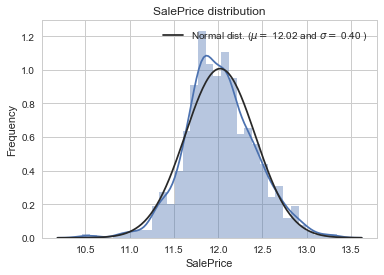

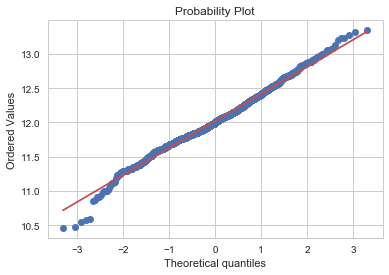

In [46]:
sns.distplot(y, fit=norm);
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y, plot=plt)
plt.show()
# mu = 12.02 and sigma = 0.40

In [47]:
train_new = train_new.drop(['Id', 'SalePrice'], axis = 1)
test_new = test_new.drop(['Id', 'SalePrice'], axis = 1)

In [48]:
print("New train dataset contains {} samples with {} features each.".format(*train_new.shape))
print("Target contains data for {} samples.".format(*y.shape))
print("New test dataset contains {} samples with {} features each.".format(*test_new.shape))

New train dataset contains 1456 samples with 291 features each.
Target contains data for 1456 samples.
New test dataset contains 1459 samples with 291 features each.


In [49]:
# metric for evaluation
def rmse(y_true, y_pred):
    diff = y_pred - y_true
    sum_sq = sum(diff**2)    
    n = len(y_pred)   
    
    return np.sqrt(sum_sq/n)

# scorer to be used in sklearn model fitting
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [50]:
def train_model(model, X, y, param_grid=[], splits=5, repeats=5):

    # create cross-validation method
    rkfold = RepeatedKFold(n_splits=splits, n_repeats=repeats)
    
    # perform a grid search if param_grid given
    if len(param_grid)>0:
        
        # setup grid search parameters
        gsearch = GridSearchCV(model, param_grid, cv=rkfold,
                               scoring=rmse_scorer,
                               verbose=1, return_train_score=True)

        # search the grid
        gsearch.fit(X,y)

        # extract best model from the grid
        model = gsearch.best_estimator_        
        best_idx = gsearch.best_index_

        # get cv-scores for best model
        grid_results = pd.DataFrame(gsearch.cv_results_)       
        cv_mean = abs(grid_results.loc[best_idx,'mean_test_score'])
        cv_std = grid_results.loc[best_idx,'std_test_score']

    # no grid search, just cross-val score for given model    
    else:
        grid_results = []
        cv_results = cross_val_score(model, X, y, scoring=rmse_scorer, cv=rkfold)
        cv_mean = abs(np.mean(cv_results))
        cv_std = np.std(cv_results)
    
    # combine mean and std cv-score in to a pandas series
    cv_score = pd.Series({'mean':cv_mean,'std':cv_std})

    # predict y using the fitted model
    y_pred = model.predict(X)
    
    # print stats on model performance         
    print('----------------------')
    print(model)
    print('----------------------')
    print('score=',model.score(X,y))
    print('rmse=',rmse(y, y_pred))
    print('cross_val: mean=',cv_mean,', std=',cv_std)
    
    # residual plots
    y_pred = pd.Series(y_pred,index=y.index)
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    z = (resid - mean_resid)/std_resid    
    n_outliers = sum(abs(z)>3)
    
    plt.figure(figsize=(15,5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y,y_pred,'.')
    plt.xlabel('y')
    plt.ylabel('y_pred');
    plt.title('corr = {:.3f}'.format(np.corrcoef(y,y_pred)[0][1]))
    ax_132=plt.subplot(1,3,2)
    plt.plot(y,y-y_pred,'.')
    plt.xlabel('y')
    plt.ylabel('y - y_pred');
    plt.title('std resid = {:.3f}'.format(std_resid))
    
    ax_133=plt.subplot(1,3,3)
    z.plot.hist(bins=50,ax=ax_133)
    plt.xlabel('z')
    plt.title('{:.0f} samples with z>3'.format(n_outliers))

    return model, cv_score, grid_results

In [51]:
# places to store optimal models and scores
opt_models = dict()
score_models = pd.DataFrame(columns=['mean','std'])

# no. k-fold splits
splits=5
# no. k-fold iterations
repeats=5

## Linear Regression - Base Models

### Ridge

In [52]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_new.values)
    rmse= np.sqrt(-cross_val_score(model, train_new.values, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [53]:
y.head()

0    12.247694
1    12.109011
2    12.317167
3    11.849398
4    12.429216
Name: SalePrice, dtype: float64

In [54]:
ridge = Ridge(alpha=236.5, copy_X=True, fit_intercept=True, max_iter=None, normalize=False, random_state=None, 
              solver='auto', tol=0.001)

### Lasso

In [55]:
lasso = Lasso(alpha=0.003100000000000001, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False, positive=False, 
               precompute=False, random_state=None, selection='cyclic', tol=0.0001, warm_start=False)


### ElasticNet

In [56]:
enet = ElasticNet(alpha=0.0009000000000000001, copy_X=True, fit_intercept=True, l1_ratio=0.9, max_iter=100000, 
                  normalize=False, positive=False, precompute=False, random_state=None, selection='cyclic', tol=0.0001, 
                  warm_start=False)

### Kernel Ridge

In [57]:
kridge = KernelRidge(alpha=1.5649999999999928, coef0=2.0, degree=2, gamma=None, kernel='polynomial', kernel_params=None)

### Tree - Based Models

#### GradientBoosting Regressor

In [58]:
gboost = GradientBoostingRegressor(n_estimators=2000, learning_rate=0.09, max_depth=1, max_features='auto', 
                                   min_samples_leaf= 2, loss='huber', random_state =1)

#### XGBoost

In [59]:
xgb = xgb.XGBRegressor(colsample_bytree=0.31071603314365653, max_depth= 3, gamma = 0.00032457863639145934, random_state=67)

#### Light GBM

In [60]:
lightgbm = lgbm.LGBMRegressor(objective='regression', num_leaves= 71, learning_rate = 0.011600000000000001, 
                               n_estimators = 850, max_bin = 100, bagging_fraction = 0.6000000000000001,
                               bagging_freq = 3, feature_fraction = 0.30000000000000004,
                               feature_fraction_seed = 9, bagging_seed = 9, min_data_in_leaf = 2, 
                                min_sum_hessian_in_leaf = 13)

#### AdaBoostRegressor

In [61]:
adaboost = AdaBoostRegressor(n_estimators=1580, learning_rate=1.3900000000000001, loss='square', random_state=42)

### Train Base Models

In [63]:
score = rmsle_cv(ridge)
print("Ridge score mean is {:.4f} and standard deviation is {:.4f}".format(score.mean(), score.std()))

score = rmsle_cv(lasso)
print("Lasso score mean is {:.4f} and standard deviation is {:.4f}".format(score.mean(), score.std()))

score = rmsle_cv(enet)
print("ElasticNet score mean is {:.4f} and standard deviation is {:.4f}".format(score.mean(), score.std()))

score = rmsle_cv(kridge)
print("KernelRidge score mean is {:.4f} and standard deviation is {:.4f}".format(score.mean(), score.std()))

score = rmsle_cv(gboost)
print("Gradient Boosting score mean is {:.4f} and standard deviation is {:.4f}".format(score.mean(), score.std()))

score = rmsle_cv(xgb)
print("Xgboost score mean is {:.4f} and standard deviation is {:.4f}".format(score.mean(), score.std()))

score = rmsle_cv(lightgbm)
print("Light GBM score mean is {:.4f} and standard deviation is {:.4f}".format(score.mean(), score.std()))

score = rmsle_cv(adaboost)
print("AdaBoost score mean is {:.4f} and standard deviation is {:.4f}".format(score.mean(), score.std()))

Ridge score mean is 0.1161 and standard deviation is 0.0047
Lasso score mean is 0.1108 and standard deviation is 0.0052
ElasticNet score mean is 0.1160 and standard deviation is 0.0055
KernelRidge score mean is 0.1130 and standard deviation is 0.0045
Gradient Boosting score mean is 0.1131 and standard deviation is 0.0043
Xgboost score mean is 0.1172 and standard deviation is 0.0074
Light GBM score mean is 0.1148 and standard deviation is 0.0056
AdaBoost score mean is 0.1551 and standard deviation is 0.0066


### Submit Code with Base Models

In [73]:
model = xgb
f_name_suffix = '\XGBoost' 

model.fit(train_new, y)
yhat = np.expm1(model.predict(test_new))
sub = pd.DataFrame()
sub['Id'] = test_id
sub['SalePrice'] = yhat
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
filename = 'submission' + f_name_suffix + '-'+ timestr + '.csv'
sub.to_csv(filename, index=False)

## Stacking Models
Thanks to https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

### Averaged Base Models


In [65]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)  

In [187]:
# Lasso, KRidge, XGBoost and Light GBM averaged score - mean is 0.1075
averaged_models = AveragingModels(models = (lasso, kridge, xgb, lightgbm))
score = rmsle_cv(averaged_models).mean()
print("Averaged score - mean is {:.4f}".format(score.mean()))

Averaged score - mean is 0.1075


### Submit Code with AveragedModels

In [177]:
averaged_models.fit(train_new, y)
yhat = np.expm1(averaged_models.predict(test_new))
sub = pd.DataFrame()
sub['Id'] = test_id
sub['SalePrice'] = yhat
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
filename = 'submission\AveragedModelsWithLassoKRidgeGBoostXGBoostAndLightGBM -'+ timestr + '.csv'
sub.to_csv(filename, index=False)

## Stacking Averaged Base Models - Adding a meta model

In [89]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X_train_local, y_train_local):
        
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        y_train_local = y_train_local.as_matrix()
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X_train_local.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X_train_local, y_train_local):
                instance = clone(model)
                self.base_models_[i].append(instance)
#                 print ('Total record is x is {}, records in y is {}, holdout_index is {} and train_index is {}'.
#                        format(X_train_local.shape, y_train_local.shape, holdout_index, train_index))
#                 print ('Datatype of X is {}'.format(type(X_train_local)))
#                 print ('Datatype of y is {}'.format(type(y_train_local)))
#                 print ('The first element in y is {}'.format(y_train_local[0]))
                
                instance.fit(X_train_local[train_index], y_train_local[train_index])
                
                y_pred = instance.predict(X_train_local[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y_train_local)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X_test_local):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X_test_local) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [95]:
np.argwhere(np.isnan(y))

array([], shape=(0, 1), dtype=int64)

In [99]:
stacked_averaged_models1 = StackingAveragedModels(base_models = (lasso, kridge, gboost, xgb, lightgbm), meta_model = enet)
score = rmsle_cv(stacked_averaged_models1)
print("Stacking Averaged models (lasso, kridge, gboost, xgb, lightgbm + enet) score mean is {:.4f} and standard deviation is {:.4f}".format(score.mean(), score.std()))

stacked_averaged_models2 = StackingAveragedModels(base_models = (lasso, kridge, gboost, xgb), meta_model = enet)
score = rmsle_cv(stacked_averaged_models2)
print("Stacking Averaged models (lasso, kridge, gboost, xgb + enet) score mean is {:.4f} and standard deviation is {:.4f}".format(score.mean(), score.std()))

stacked_averaged_models3 = StackingAveragedModels(base_models = (lasso, kridge, xgb, lightgbm), meta_model = enet)
score = rmsle_cv(stacked_averaged_models3)
print("Stacking Averaged models (lasso, kridge, xgb, lightgbm + enet) score mean is {:.4f} and standard deviation is {:.4f}".format(score.mean(), score.std()))

stacked_averaged_models4 = StackingAveragedModels(base_models = (enet, kridge, gboost, xgb, lightgbm), meta_model = lasso)
score = rmsle_cv(stacked_averaged_models4)
print("Stacking Averaged models (enet, kridge, gboost, xgb, lightgbm + lasso) score mean is {:.4f} and standard deviation is {:.4f}".format(score.mean(), score.std()))

stacked_averaged_models5 = StackingAveragedModels(base_models = (ridge, lasso, kridge, gboost, xgb, lightgbm), meta_model = enet)
score = rmsle_cv(stacked_averaged_models5)
print("Stacking Averaged models (ridge, lasso, kridge, gboost, xgb, lightgbm + enet) score mean is {:.4f} and standard deviation is {:.4f}".format(score.mean(), score.std()))

stacked_averaged_models6 = StackingAveragedModels(base_models = (lasso, enet, gboost, xgb, lightgbm), meta_model = kridge)
score = rmsle_cv(stacked_averaged_models6)
print("Stacking Averaged models (lasso, enet, gboost, xgb, lightgbm + kridge) score mean is {:.4f} and standard deviation is {:.4f}".format(score.mean(), score.std()))

Stacking Averaged models (lasso, kridge, gboost, xgb, lightgbm + enet) score mean is 0.1070 and standard deviation is 0.0046
Stacking Averaged models (lasso, kridge, gboost, xgb + enet) score mean is 0.1076 and standard deviation is 0.0047
Stacking Averaged models (lasso, kridge, xgb, lightgbm + enet) score mean is 0.1075 and standard deviation is 0.0045
Stacking Averaged models (enet, kridge, gboost, xgb, lightgbm + lasso) score mean is 0.1078 and standard deviation is 0.0049
Stacking Averaged models (ridge, lasso, kridge, gboost, xgb, lightgbm + enet) score mean is 0.1070 and standard deviation is 0.0046
Stacking Averaged models (lasso, enet, gboost, xgb, lightgbm + kridge) score mean is 0.1074 and standard deviation is 0.0046


### Ensembling

In [98]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

#### StackedRegressor

In [118]:
stacked_averaged_models = stacked_averaged_models6
stacked_averaged_models.fit(train_new.values, y)
stacked_train_pred = stacked_averaged_models.predict(train_new.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test_new.values))
print(rmsle(y, stacked_train_pred))

0.07792116855524281


#### Submit

In [119]:
sub = pd.DataFrame()
sub['Id'] = test_id
sub['SalePrice'] = stacked_pred
import time
timestr = time.strftime("%Y%m%d-%H%M%S")

filename = 'submission\StackedModelsWithLassoENetGBoostXGBoostLightGBMPlusKRidge -'+ timestr + '.csv'
sub.to_csv(filename, index=False)